# Which Wine Is It, Anyway?
### A Simulation-Based Analysis of Judging A Wine's Quality

A group of 40 people were given two wines to taste: a good wine, and a cheap wine. After tasting each wine, they were asked to tell whether or not they could taste a difference between the two wines.

In this exercise, we'll use simulations to answer the following question:

## Did our taste testers do a good job of determining whether there was a difference between these two wines?

# Setup

To begin, we'll import our standard data analysis libraries: `pandas`, `matplotlib`, and `numpy`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Building Our Simulation

For simulation purposes, we'll begin with the assumption that any given person has absolutely no nose whatsoever for wine, and that they'll always guess randomly as to how good a wine is. We'll also want to run a large number of simulations so that we can get a good sense of just what this "random" comparison would look like. 

To do this, we'll start by creating an empty data frame with five columns: ID numbers for each simulation and participant, their quality guess for a "good" wine, their quality guess for a "cheap" wine, and their actual response to the question "can you tell the difference between these two wines?"

In [2]:
simulationDF = pd.DataFrame(columns = ['simulationID', 'participantID', 'goodWineGuess', 'cheapWineGuess', 'surveyResponse'])
simulationDF.head()

,simulationID,participantID,goodWineGuess,cheapWineGuess,surveyResponse


Now, let's populate our simulation data. Let's do 100,000 simulations with 100 participants each, which will be a total of 10,000,000 records.

We'll start by assigning each participant's random rating for each wine a value between 0 (terrible) and 100 (amazing). This will both generate the values we'll use in our simulations and define the size of our dataframe.

Once we've done that, we'll assign simulationIDs and participantIDs so we can tell the simulation runs apart.

In [14]:
totalSimulationCount = 100000
totalParticipantCount = 100

simulationDF['goodWineGuess'] = np.random.randint(0,100, size=(totalSimulationCount * totalParticipantCount))
simulationDF['cheapWineGuess'] = np.random.randint(0,100, size=(totalSimulationCount * totalParticipantCount))

simulationDF['simulationID'] = (np.floor(simulationDF.index / totalParticipantCount) + 1).astype('int')
simulationDF['participantID'] = ((simulationDF.index % totalParticipantCount) + 1).astype('int')

simulationDF.head()

,simulationID,participantID,goodWineGuess,cheapWineGuess,surveyResponse
0,1,1,85,71,1
1,1,2,94,57,0
2,1,3,78,72,1
3,1,4,35,57,1
4,1,5,21,64,1


Now that we have each participant's guess as to the quality of a wine, we can determine each person's response.

Here's where things get a little subjective. Each participant has given a score for each of our two wines, so let's take this problem at face value. Any time the "cheap" and "good" scores are exactly the same, the participant can't tell the difference, so we mark `surveyResponse` as `False`. Otherwise, we mark it as `True`.

Let's see what happens!

In [15]:
simulationDF['surveyResponse'] = (simulationDF['goodWineGuess'] != simulationDF['cheapWineGuess']).astype('int')

simulationDF.head(50)

# let's view the first 50 records, which happens to represent the entirety of our first simulation run!

,simulationID,participantID,goodWineGuess,cheapWineGuess,surveyResponse
0,1,1,85,71,1
1,1,2,94,57,1
2,1,3,78,72,1
3,1,4,35,57,1
4,1,5,21,64,1
5,1,6,93,22,1
6,1,7,69,76,1
7,1,8,71,55,1
8,1,9,44,95,1
9,1,10,10,23,1


...if we group our results by simulation ID and add up our `surveyResponse` column, we'll get the total number of accurate guesses–that is, people who said they could tell a difference between the two wines:

In [16]:
outcomeDF = simulationDF[['simulationID', 'surveyResponse']]


outcomeDF = outcomeDF.groupby(['simulationID'], as_index=False).sum()

outcomeDF.head()

,simulationID,surveyResponse
0,1,100
1,2,99
2,3,99
3,4,98
4,5,99


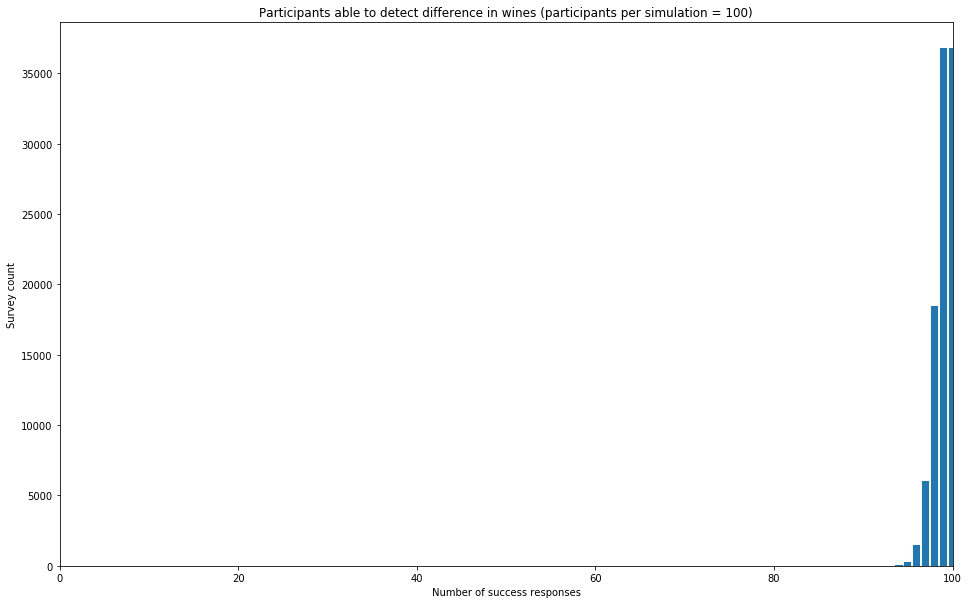

In [17]:
plotDF = outcomeDF.groupby(['surveyResponse'], as_index=False).count()


plt.title("Participants able to detect difference in wines (participants per simulation = " + str(totalParticipantCount) + ")")
plt.xlabel("Number of success responses")
plt.ylabel("Survey count")
plt.bar(plotDF['surveyResponse'], plotDF['simulationID'])
plt.xlim(0, totalParticipantCount)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

Well this is...*pretty useless!*

Of course, the problem with this approach is immediately apparent: with a 0-100 scale, the odds of a respondent getting the *exact same quality guess* for each wine are very low. Thus, virtually *everybody* says they can tell **a** difference between the two, however small! That's not going to work!

We can fix this by introducing an additional parameter: `wiggleFactor`. 

Let's treat the guess values not as actual scores provided by the participants, but rather as a quantification of each participant's "feeling" about the wine. Since we're not good at quantifying things like feelings and opinions, we'll introduce the concept of a "wiggle factor" to our model. The wiggle factor will allow two scores that are *close* but not *exactly the same* to be interpreted as "too close to tell apart" by the participant. Thus, if two scores are within `wiggleFactor` points of each other, the participant will judge them as being effectively equal.

Instead of using an expensive absolute value function to determine the difference between our judged values, we'll simply square the difference between each score and compare it to the square of the wiggle factor. If the square of the difference is less than the square of the wiggle factor, then we'll call the two guesses "close enough" to be the same.

Another way to make this adjustment is to reduce the scoring range. For example, a 1-10 scale should return roughly the same results as using a `wiggleFactor` of 10 on our 0-100 range. I'm going to stick with `wiggleFactor` for now, though, as we may want to tweak it along the way.

In [7]:
wiggleFactor = 10

# square the wiggle factor for comparison
wiggleFactorSquared = wiggleFactor * wiggleFactor

simulationDF['surveyResponse'] = (((simulationDF['goodWineGuess'] - simulationDF['cheapWineGuess']) * (simulationDF['goodWineGuess'] - simulationDF['cheapWineGuess'])) >= wiggleFactorSquared).astype('int')

outcomeDF = simulationDF[['simulationID', 'surveyResponse']]


outcomeDF = outcomeDF.groupby(['simulationID'], as_index=False).sum()


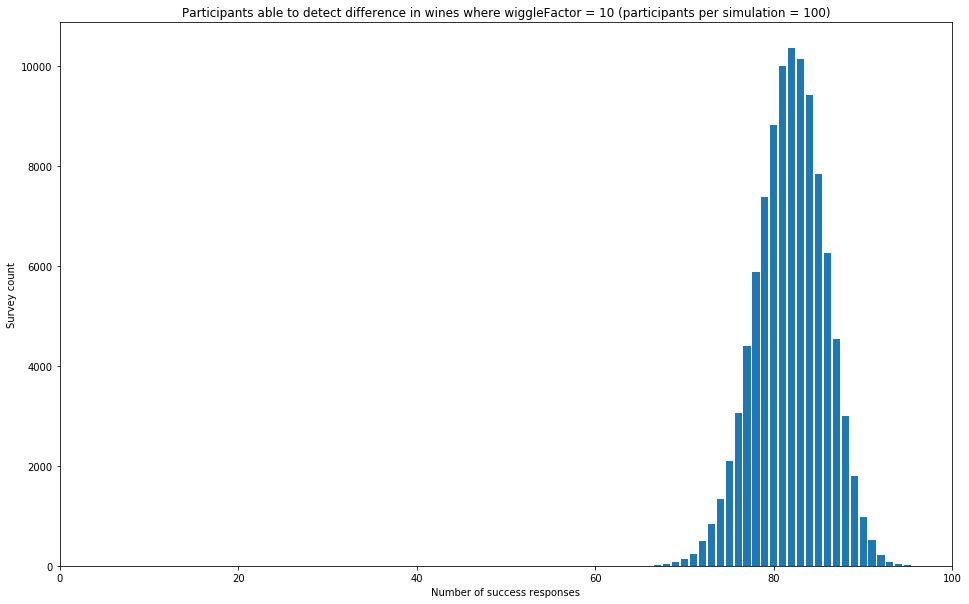

In [8]:
plotDF = outcomeDF.groupby(['surveyResponse'], as_index=False).count()


plt.title("Participants able to detect difference in wines where wiggleFactor = " + str(wiggleFactor) + " (participants per simulation = " + str(totalParticipantCount) + ")")
plt.xlabel("Number of success responses")
plt.ylabel("Survey count")
plt.bar(plotDF['surveyResponse'], plotDF['simulationID'])
plt.xlim(0, totalParticipantCount)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

Now we're getting somewhere! It turns out that if respondents have some wiggle room when judging a wine, we get a nice, clear curve instead of a lump of results at the high end. This is great!

But is it what we want? After all, we're only asking if they can *tell a difference*. We're not asking if they can tell good from bad.

Let's re-run this analysis, but this time, we'll only count a response as successful if they can tell a difference between the two wines *and* they accurately identify the "good" wine as being better than the "cheap" wine.

Here goes!

In [9]:
wiggleFactor = 10

# square the wiggle factor for comparison
wiggleFactorSquared = wiggleFactor * wiggleFactor

simulationDF['surveyResponse'] = (((simulationDF['goodWineGuess'] - simulationDF['cheapWineGuess']) * (simulationDF['goodWineGuess'] - simulationDF['cheapWineGuess'])) >= wiggleFactorSquared).astype('int')

# this time, only count guesses as accurate if the "good" guess is higher than the "cheap" guess!

simulationDF['surveyResponse'] = simulationDF['surveyResponse'] * (simulationDF['goodWineGuess'] > simulationDF['cheapWineGuess'])

outcomeDF = simulationDF[['simulationID', 'surveyResponse']]


outcomeDF = outcomeDF.groupby(['simulationID'], as_index=False).sum()

outcomeDF.head()


,simulationID,surveyResponse
0,1,41
1,2,43
2,3,41
3,4,46
4,5,40


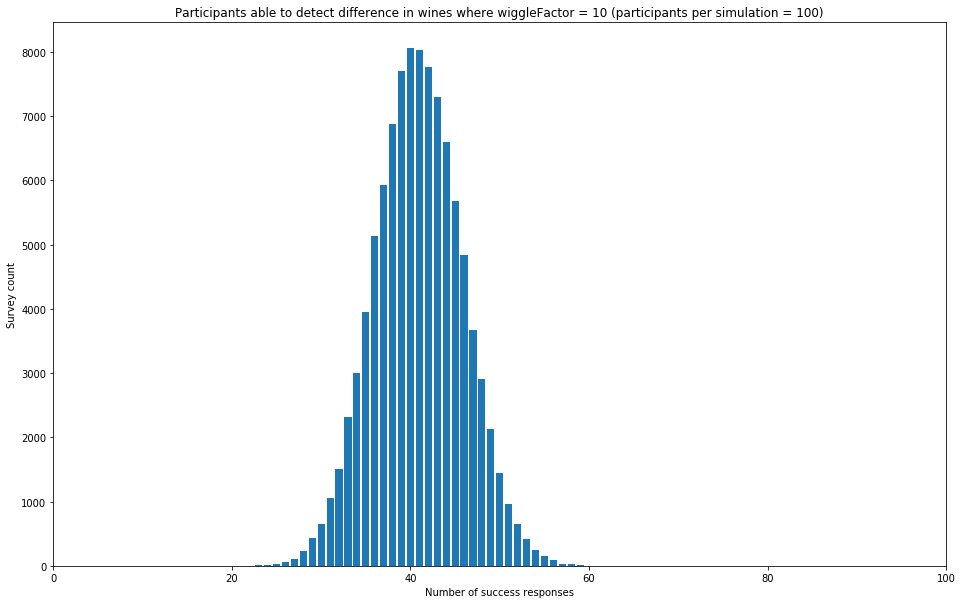

In [10]:
plotDF = outcomeDF.groupby(['surveyResponse'], as_index=False).count()


plt.title("Participants able to detect difference in wines where wiggleFactor = " + str(wiggleFactor) + " (participants per simulation = " + str(totalParticipantCount) + ")")
plt.xlabel("Number of success responses")
plt.ylabel("Survey count")
plt.bar(plotDF['surveyResponse'], plotDF['simulationID'])
plt.xlim(0, totalParticipantCount)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

Ohhhhh, now *this* is interesting! If we don't count people who guessed the wrong wine as being the expensive wine, our numbers drop *considerably*!

Now, with our given values, we can see a peak at 41 "success" responses–that is, in most of our simulations, 41 people accurately guessed which wine was actually the good wine–which means that in our simulations, the most common outcome was for 41% of respondents to accurately guess which wine was good and which wine was cheap!

# Are Human Senses Really *That* Useless, Though?

So far, we've assumed that humans are basically useless at being able to taste wine. While this is a satisfying assumption to make if you're someone who dislike wine snobs, it isn't necessarily going to be accurate. What if people actually *can* tell the difference between a good wine and a cheap wine–at least to an extent? 

After all, if you give someone a salad that's made of wilted lettuce, a slice of processed American cheese, and covered in hot sauce, most people will be able to identify that as a **bad** salad. Show someone a rusted-out hatchback with duct-tape over its front panel and an assortment of colorful fluids slowly pooling underneath the engine, and most people will be able to identify that as a **bad** car. 

Why should wine be any different? Let's assume that people can, at the very least, form a vague judgement on the actual quality of a wine that's usually reasonably close to the actual quality of that wine.

### Moar Variables

Let's start by quantifying the value of our two wines, based on the assumption that the "good" wine actually *is* quantifiably better than our "cheap" wine. While I've had some delicious "cheap" wines and some nondescript "good" wines in my life, there *are* very real–and significant–qualitative differences between wines. It can depend on a person's palatte, certainly, but at some point, people come to consensus that a given wine is better or worse than another wine.

So for our exercise, let's assume the following: a group of expert judges have tried both our "good" and "cheap" wine, and have given each wine a score on the same scale as our respondents are using. Let's say that the "cheap" wine scored a 40, and our "good" wine scored a 70.

Now, let's further assume that the average person can *roughly* tell a good wine from a bad wine, and that they're not likely to give a bottle of rotgut a full 100 points, nor are they likely to give a perfectly aged grand cru Bordeaux a 0. Let's assume that the average person can predict a wine's judged quality within some `accuracyValue`.

We'll say our average person has an `accuracyValue` of 20 points, meaning that when they're guessing the quality of a wine, their guess will fall on a *normal distribution* where the standard deviation is equal to 20. Note that this doesn't mean that the guess is *bounded* by 20 points; rather, that's where the first standard deviation falls.

In [11]:
judgedScoreCheap = 40
judgedScoreGood = 70

accuracyRange = 20


#simulationDF['goodWineGuess'] = np.random.randint(0,100, size=(totalSimulationCount * totalParticipantCount))
#simulationDF['cheapWineGuess'] = np.random.randint(0,100, size=(totalSimulationCount * totalParticipantCount))

simulationDF['goodWineGuess'] = np.clip(np.random.normal(loc=judgedScoreGood, scale=accuracyRange, size=(totalSimulationCount * totalParticipantCount)), 0,100).astype('int')
simulationDF['cheapWineGuess'] = np.clip(np.random.normal(loc=judgedScoreCheap, scale=accuracyRange, size=(totalSimulationCount * totalParticipantCount)), 0, 100).astype('int')

simulationDF['simulationID'] = (np.floor(simulationDF.index / totalParticipantCount) + 1).astype('int')
simulationDF['participantID'] = ((simulationDF.index % totalParticipantCount) + 1).astype('int')

# we'll calculate survey responses in a moment.
simulationDF['surveyResponse'] = np.NaN

simulationDF.head()

,simulationID,participantID,goodWineGuess,cheapWineGuess,surveyResponse
0,1,1,65,40,NaN
1,1,2,56,64,NaN
2,1,3,95,12,NaN
3,1,4,73,0,NaN
4,1,5,49,11,NaN


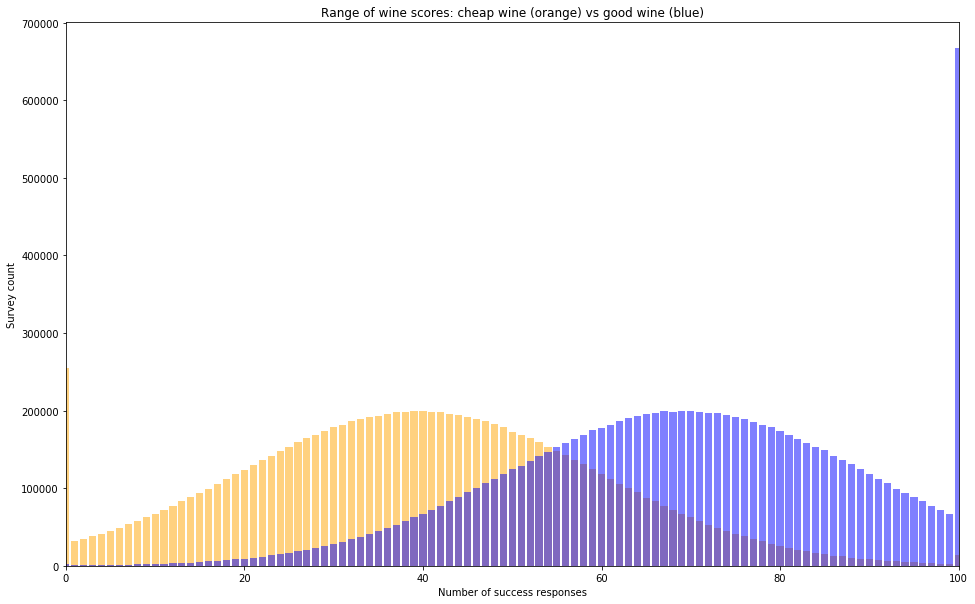

In [12]:
plotDF = simulationDF[['cheapWineGuess', 'participantID']]
plotDF = plotDF.groupby(['cheapWineGuess'], as_index=False).count()



plt.title("Range of wine scores: cheap wine (orange) vs good wine (blue)")
plt.xlabel("Number of success responses")
plt.ylabel("Survey count")
plt.bar(plotDF['cheapWineGuess'], plotDF['participantID'], color='orange', alpha=0.5)

plotDF = simulationDF[['goodWineGuess', 'participantID']]
plotDF = plotDF.groupby(['goodWineGuess'], as_index=False).count()
plt.bar(plotDF['goodWineGuess'], plotDF['participantID'], color='b', alpha=0.5)


plt.xlim(0, totalParticipantCount)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

Now we can easily see that if people have *some* sense of the quality of the wine they're drinking, we can produce a model where we start to see guess ranges that make some sense. Very few people gave the cheap wine a rating of over ninety; very few people gave the good wine a rating of under twenty.

Note we have some spikes at either end of the scale. In this simulation, I'm using the `numpy` `clip()` function to force all values under 0 to be 0, and all values over 100 to be 100. In reality, I'd imagine that we'd see less pronounced spikes at either end of the graph, with those spikes more evenly distributed over the low/high range of the graph, respectively.

Now, let's repeat our last comparison analysis, using the `wiggleFactor` and only marking people who correctly guess the good and cheap wines as a success response.

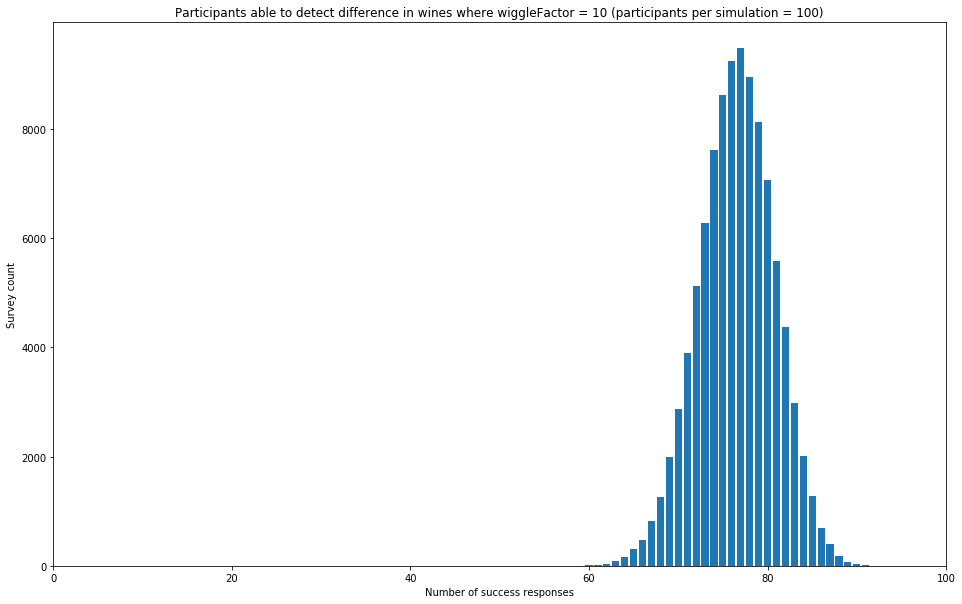

In [13]:
wiggleFactor = 10

# square the wiggle factor for comparison
wiggleFactorSquared = wiggleFactor * wiggleFactor

simulationDF['surveyResponse'] = (((simulationDF['goodWineGuess'] - simulationDF['cheapWineGuess']) * (simulationDF['goodWineGuess'] - simulationDF['cheapWineGuess'])) >= wiggleFactorSquared).astype('int')
simulationDF['surveyResponse'] = simulationDF['surveyResponse'] * (simulationDF['goodWineGuess'] > simulationDF['cheapWineGuess'])

outcomeDF = simulationDF[['simulationID', 'surveyResponse']]


outcomeDF = outcomeDF.groupby(['simulationID'], as_index=False).sum()

plotDF = outcomeDF.groupby(['surveyResponse'], as_index=False).count()


plt.title("Participants able to detect difference in wines where wiggleFactor = " + str(wiggleFactor) + " (participants per simulation = " + str(totalParticipantCount) + ")")
plt.xlabel("Number of success responses")
plt.ylabel("Survey count")
plt.bar(plotDF['surveyResponse'], plotDF['simulationID'])
plt.xlim(0, totalParticipantCount)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

As we'd expect, our success rate shot up once we defined judged scores for each wine and assumed that the people trying the wine had some ability to judge the wine's quality, instead of having them randomly guess at each wine's quality.

# Summary

So we've run a few simulations with a few different parameters:

- Random guesses, with a pedantically literal "do these wines match" criteria: **~99% "accuracy"**
- Random guesses with a more nuanced "wiggle room" comparison: **~83% "accuracy"**
- Random guesses with "wiggle room", only counting guesses that correctly choose the good wine: **~41% accuracy**
- Judged values for each wine with "smart" guesses and "wiggle room" comparison: **~77% accuracy**

It's important to note that for our first two tests, we have a different success criteria than we do for our last two tests. It's also important to note that we're making rough assumptions throughout for things like `wiggleFactor`, our judged wine values, and `accuracyRange`. If we were to keep tweaking these values, we'd be able to get vastly different outcomes.

So. As with so many things, the answer to our original question,


## Did our taste testers do a good job of determining whether there was a difference between these two wines?

the answer is:

# It depends!

We made a number of assumptions to build our models, all of which are quite simple. To build richer models, we'd need to make a *lot more assumptions* about our wines and our testing population. 

We also need to know a lot more about our live taste test, as well: how well do the participants know their wine? Have they *ever* tried wine, and do they know what qualities make a wine *good*? Is the cheap wine particularly good, and is the good wine *expensive* but not necessarily *good*?

### Bibliography

1. https://kite.com/python/answers/how-to-create-an-empty-dataframe-with-column-names-in-python
1. https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it
1. https://stackoverflow.com/questions/30327417/pandas-create-new-column-in-df-with-random-integers-from-range
1. https://www.geeksforgeeks.org/how-to-get-rows-index-names-in-pandas-dataframe/
1. https://stackoverflow.com/questions/27592456/floor-or-ceiling-of-a-pandas-series-in-python/27592499
1. https://stackoverflow.com/questions/22105452/what-is-the-equivalent-of-sql-group-by-having-on-pandas?lq=1
1. https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
1. https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.xlim.html
1. https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html
1. https://www.geeksforgeeks.org/numpy-clip-in-python/